In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser as parser
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import hvplot.pandas
from holoviews import opts, dim
from geopandas import GeoDataFrame, read_file
from os.path import exists
from urllib.request import urlretrieve

In [7]:
# Read csv file as a dataframe
raw_ship_data = pd.read_csv('data.csv')
print(f"Finished reading {len(raw_ship_data)} lines of data")

Finished reading 1003 lines of data


In [8]:
raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID
0,2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,28,107,15,15,4.5,5
1,2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,7,21,2,7,2.4,5
2,2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,138,20,20,4,10.0,5
3,2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,18,32,5,5,2.4,5
4,2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5


In [9]:
# Print the columns of our data
print(raw_ship_data.columns)

Index(['time_utc', 'CallSign', 'ShipName', 'Type', 'ImoNumber', 'MMSI',
       'latitude', 'longitude', 'Destination', 'FixType', 'Dimension A',
       'Dimension B', 'Dimension C', 'Dimension D', 'MaximumStaticDraught',
       'MessageID'],
      dtype='object')


Με μία επισκόπηση του επιστρεφόμενου πίνακα, παρατηρούμε πως θα χρειαστεί να προχωρήσουμε σε ορισμένες αλλαγές προκειμένου να διευκολυνθούμε στη μετέπειτα επεξεργασία. Πιο συγκεκριμένα θα διαμορφώσουμε τα στοιχεία χρόνου, συντεταγμένων και διαστάσεων.

In [19]:
# Coordinates format to point format for plotting and visualization
geo_raw_ship_data = gpd.GeoDataFrame(raw_ship_data, geometry=gpd.points_from_xy(raw_ship_data.longitude, raw_ship_data.latitude), crs="EPSG:4326")
geo_raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID,geometry
0,2023-12-09 08:05:51.944186364 +0000 UTC,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,28,107,15,15,4.5,5,POINT (33.05835 34.66968)
1,2023-12-09 08:05:54.203014122 +0000 UTC,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,7,21,2,7,2.4,5,POINT (33.00969 34.64540)
2,2023-12-09 08:05:57.546130448 +0000 UTC,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,138,20,20,4,10.0,5,POINT (29.00512 35.82620)
3,2023-12-09 08:06:05.451479994 +0000 UTC,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,18,32,5,5,2.4,5,POINT (33.00900 34.64513)
4,2023-12-09 08:06:08.806450979 +0000 UTC,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5,POINT (33.01678 34.65245)


In [20]:
#Parse time column as timestamp and reshape time format
geo_raw_ship_data['time_utc'] = pd.to_datetime(geo_raw_ship_data['time_utc'], format='%Y-%m-%d %H:%M:%S.%f %z UTC')
geo_raw_ship_data['time_utc'] = geo_raw_ship_data['time_utc'].dt.strftime("%Y-%m-%d %H:%M:%S")
geo_raw_ship_data.head()

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID,geometry
0,2023-12-09 08:05:51,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,28,107,15,15,4.5,5,POINT (33.05835 34.66968)
1,2023-12-09 08:05:54,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,7,21,2,7,2.4,5,POINT (33.00969 34.64540)
2,2023-12-09 08:05:57,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,138,20,20,4,10.0,5,POINT (29.00512 35.82620)
3,2023-12-09 08:06:05,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,18,32,5,5,2.4,5,POINT (33.00900 34.64513)
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,21,154,24,6,0.0,5,POINT (33.01678 34.65245)


In [21]:
# Collapsing dimension columns
geo_raw_ship_data['length'] = (geo_raw_ship_data['Dimension A'] + geo_raw_ship_data['Dimension B'])
geo_raw_ship_data['width'] = (geo_raw_ship_data['Dimension C'] + geo_raw_ship_data['Dimension D'])
geo_raw_ship_data = geo_raw_ship_data.drop(columns=['Dimension A', 'Dimension B', 'Dimension C', 'Dimension D'])

In [22]:
# Find the vessels with "0" values in their dimensions
length_dimension = geo_raw_ship_data[(geo_raw_ship_data['length']==0)]
width_dimension = geo_raw_ship_data[(geo_raw_ship_data['width']==0)]
print(length_dimension['Type'].unique())
print(width_dimension['Type'].unique())

[70 52  0]
[70 52  0]


70 = cargo,
52 = Tug,
0 = default,

In [23]:
# Get all the ships that are of type cargo, tug, default
cargo = geo_raw_ship_data[(geo_raw_ship_data['Type'] == 70)]
tug = geo_raw_ship_data[(geo_raw_ship_data['Type'] == 52)]
default = geo_raw_ship_data[(geo_raw_ship_data['Type'] == 0)]

In [24]:
# Calculate the mean value of their dimensions
cargo_mean_length = int(cargo['length'].mean())
cargo_mean_width = int(cargo['width'].mean())

tug_mean_length = int(tug['length'].mean())
tug_mean_width = int(tug['width'].mean())

default_mean_length = int(default['length'].mean())
default_mean_width = int(default['width'].mean())

In [25]:
# Replace the zero values with the mean value
geo_raw_ship_data.loc[(geo_raw_ship_data['length'] == 0) & (geo_raw_ship_data['Type']==70), ['length']] = cargo_mean_length
geo_raw_ship_data.loc[(geo_raw_ship_data['width'] == 0) & (geo_raw_ship_data['Type']==70), ['width']] = cargo_mean_width

geo_raw_ship_data.loc[(geo_raw_ship_data['length'] == 0) & (geo_raw_ship_data['Type']==52), ['length']] = tug_mean_length
geo_raw_ship_data.loc[(geo_raw_ship_data['width'] == 0) & (geo_raw_ship_data['Type']==52), ['width']] = tug_mean_width

geo_raw_ship_data.loc[(geo_raw_ship_data['length'] == 0) & (geo_raw_ship_data['Type']==0), ['length']] = default_mean_length
geo_raw_ship_data.loc[(geo_raw_ship_data['length'] == 0) & (geo_raw_ship_data['Type']==0), ['width']] = tug_mean_width

In [26]:
# Get the shape of our dataframe
raw_ship_data.shape

(1003, 16)

(NaN ή null τιμές) στο DataFrame raw_ship_data
df.isnull(),  'NaN' τμές θα απαντήσει σε True or False.
True αν βρεί τέτοιες τιμές και False αντίστοιχα 

df.isnull().any().any()- Το πρώτο .any() ελέγχει εάν υπάρχει τουλάχιστον μία τιμή True κατά μήκος κάθε στήλης και το δεύτερο .any() ελέγχει εάν υπάρχει τουλάχιστον μία τιμή True σε όλες τις στήλες δινει True αν λειπουν τιμες και False αν δεν λειπουν

In [27]:
# Print missing values
print("Any missing values:", geo_raw_ship_data.isnull().any().any())

# Count missing values
null_counts_total = geo_raw_ship_data.isnull().sum().sum()
print("null_counts_total:", null_counts_total)

Any missing values: True
null_counts_total: 81


In [28]:
#  Print dataframe null values in each column
null_counts = geo_raw_ship_data.isnull().sum()
print("Null counts in each column:") 
print(null_counts)

Null counts in each column:
time_utc                 0
CallSign                17
ShipName                 0
Type                     0
ImoNumber                0
MMSI                     0
latitude                 0
longitude                0
Destination             64
FixType                  0
MaximumStaticDraught     0
MessageID                0
geometry                 0
length                   0
width                    0
dtype: int64


In [29]:
# Rows with at least one null value:
geo_raw_ship_data[geo_raw_ship_data.isnull().any(axis=1)]

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,geometry,length,width
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,POINT (33.01678 34.65245),175,30
20,2023-12-09 08:07:43,NaN,ASHDOD PORT,0,0,4282000,31.831317,34.639927,NaN,0,0.0,5,POINT (34.63993 31.83132),236,32
32,2023-12-09 08:08:52,NaN,ASHDOD PORT,0,0,4282000,31.831242,34.639950,NaN,1,0.0,5,POINT (34.63995 31.83124),236,32
68,2023-12-09 08:12:54,P3CQ9,PETSAS I,0,0,209352000,34.664468,33.029690,NaN,15,0.0,5,POINT (33.02969 34.66447),87,0
77,2023-12-09 08:13:34,EAPC,EAPC CONTROL,0,0,428990000,31.642125,34.531130,NaN,1,0.0,5,POINT (34.53113 31.64213),87,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,2023-12-09 09:33:59,XCAN5,ADMIRAL,31,0,345050010,34.673365,33.066440,NaN,0,0.0,5,POINT (33.06644 34.67336),38,10
958,2023-12-09 09:36:10,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652465,33.016780,NaN,1,0.0,5,POINT (33.01678 34.65246),175,30
967,2023-12-09 09:36:44,XCAN5,ADMIRAL,31,9421582,345050010,34.673347,33.066408,NaN,1,0.0,5,POINT (33.06641 34.67335),38,10
976,2023-12-09 09:37:31,EAPC,EAPC CONTROL,0,0,428990000,31.642107,34.531045,NaN,1,0.0,5,POINT (34.53104 31.64211),87,0


In [30]:
# Def null values 
def rows_with_null_values(dataframe, column_name = None):
    if column_name is None:
        return dataframe[dataframe.isnull().any(axis = 1)]
    else:
        return dataframe[dataframe[column_name].isnull()]

In [31]:
rows_with_null_values(raw_ship_data, column_name = "CallSign")

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,Dimension A,Dimension B,Dimension C,Dimension D,MaximumStaticDraught,MessageID
20,2023-12-09 08:07:43.529290641 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831317,34.639927,NaN,0,0,236,0,32,0.0,5
32,2023-12-09 08:08:52.471973589 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831242,34.639950,NaN,1,191,45,22,10,0.0,5
93,2023-12-09 08:14:51.427148033 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831232,34.639995,NaN,1,191,45,22,10,0.0,5
150,2023-12-09 08:20:51.080426955 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831103,34.640052,NaN,1,191,45,22,10,0.0,5
210,2023-12-09 08:26:51.933645457 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831085,34.640077,NaN,1,191,45,22,10,0.0,5
269,2023-12-09 08:32:58.220652051 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831223,34.639997,NaN,1,191,45,22,10,0.0,5
328,2023-12-09 08:38:57.410927269 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831207,34.640012,NaN,1,191,45,22,10,0.0,5
391,2023-12-09 08:44:53.199424716 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831207,34.640012,NaN,1,191,45,22,10,0.0,5
460,2023-12-09 08:50:55.616028787 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831207,34.640012,NaN,1,191,45,22,10,0.0,5
524,2023-12-09 08:56:59.340063451 +0000 UTC,NaN,ASHDOD PORT,0,0,4282000,31.831207,34.640012,NaN,1,191,45,22,10,0.0,5


In [32]:
# Print number of unique call signs
print("Number of unique call signs:", geo_raw_ship_data["CallSign"].nunique())

Number of unique call signs: 91


In [33]:
# Dataframe unique values overview
geo_raw_ship_data.nunique()

time_utc                909
CallSign                 91
ShipName                 91
Type                     24
ImoNumber                76
MMSI                     92
latitude                752
longitude               742
Destination              44
FixType                   5
MaximumStaticDraught     49
MessageID                 1
geometry                886
length                   67
width                    27
dtype: int64

Απο το παραπάνω αποτέλεσμα παρατηρούμε διαφορά μεταξύ του πλήθους των callsign και των MMSI, ωστόσο επειδή ο κωδικός MSSI αποτελεί κλειδί αναζήτησης θα αναζητούμε με βάση αυτό.

In [34]:
# Find the number of unique ships inside of our table using as key the MMSI since it has no 0 values and it is an ID attribute
print(np.sort(geo_raw_ship_data['MMSI'].unique()))

[  4282000 209005000 209166000 209343000 209352000 209492000 209511000
 209969000 210282000 210330000 210588000 210595000 211920000 212212000
 212230000 212319000 212541000 212717000 212858000 212872000 215013000
 215209000 229447000 233303000 235090927 236723000 241776000 244810178
 247274900 248823000 255806109 255977000 255979000 256060000 256081000
 256251000 257073920 271044343 271047045 271051041 271052043 305299000
 305384000 311000706 312349000 319222400 319234300 319287000 345050010
 352002159 352002364 352002749 353822000 371343000 375369000 428000112
 428000407 428007000 428009070 428045000 428066000 428068000 428990000
 470763000 511100389 511100460 511100504 511100835 518998397 538002973
 538003685 538007432 538009102 538009176 563112000 572705210 577171000
 613226010 613871403 622113180 630001049 636014902 636015074 636019201
 636021330 636021691 636022888 667001448 667001603 668116210 671290100
 987170323]


In [35]:
# Get a dataframe with only the single ships
unique_ships = geo_raw_ship_data.drop_duplicates(subset=['MMSI'])
display(unique_ships)

,time_utc,CallSign,ShipName,Type,ImoNumber,MMSI,latitude,longitude,Destination,FixType,MaximumStaticDraught,MessageID,geometry,length,width
0,2023-12-09 08:05:51,IBRV,SEMINOLE,90,7645550,247274900,34.669683,33.058350,CYLMS,1,4.5,5,POINT (33.05835 34.66968),135,30
1,2023-12-09 08:05:54,5BLV2,EDT ZENON,52,9315977,212541000,34.645403,33.009685,LIMASSOL,1,2.4,5,POINT (33.00969 34.64540),28,9
2,2023-12-09 08:05:57,TCA5645,KOSOVAK,71,9211157,271047045,35.826203,29.005122,TRALI,1,10.0,5,POINT (29.00512 35.82620),158,24
3,2023-12-09 08:06:05,5BFB3,EDT LEON,91,9575400,209343000,34.645127,33.008998,LIMASSOL,0,2.4,5,POINT (33.00900 34.64513),50,10
4,2023-12-09 08:06:08,GDSA,NAVAL AUXILIARY A135,34,7822550,233303000,34.652447,33.016777,NaN,1,0.0,5,POINT (33.01678 34.65245),175,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,2023-12-09 09:09:12,V7SN2,DANCHOR IX,99,9316787,538003685,32.814877,35.030665,NaN,1,2.1,5,POINT (35.03066 32.81488),59,9
664,2023-12-09 09:09:29,3E3832,NOVA CORALIA,70,8918409,352002159,32.818160,35.016760,IL HFA,1,7.1,5,POINT (35.01676 32.81816),119,18
668,2023-12-09 09:09:38,5BWY5,LEDRA EXPLORER,52,0,210330000,34.541397,33.239995,LIMASSOL CYPRUS,0,3.0,5,POINT (33.24000 34.54140),39,9
839,2023-12-09 09:25:02,V7A4413,STELLAR LADY,70,9574004,538009176,30.142940,32.569717,CANAKKALE,1,6.3,5,POINT (32.56972 30.14294),183,32


In [38]:
# Find the different type of ships
ship_type = unique_ships['Type'].unique()
print(np.sort(ship_type))

[ 0 31 33 34 35 37 40 50 51 52 59 60 68 69 70 80 82 89 90 91 92 99]


 0  = default,
 31 = Towing,
 33 = Dredging,
 34 = Diving,
 35 = Military,
 37 = Pleasure,
 40 = HighSpeedCraft (HSC),
 50 = Pilot,
 51 = SAR,
 52 = Tug,
 59 = Noncombatant,
 60 = Passenger,
 68 = Passenger Reserved for future use,
 69 = Passenger No additional information,
 70 = Cargo all ships of this type,
 71 = Cargo Hazardous category A,
 79 = Cargo No additional information,
 80 = Tanker all ships of this type,
 82 = Tanker Hazardous category B,
 89 = Tanker No additional information,
 90 = Other Type all ships of this type,
 91 = Other Type Hazardous category A,
 92 = Other Type Hazardous category B,
 99 = Other Type no additional information

In [44]:
# Collapse vessel subcategories to categories
unique_ships.loc[(unique_ships['Type'] == 71) | (unique_ships['Type'] == 79)] = 70
unique_ships.loc[(unique_ships['Type'] == 68) | (unique_ships['Type'] == 69)] = 60
unique_ships.loc[(unique_ships['Type'] == 82) | (unique_ships['Type'] == 89)] = 80
unique_ships.loc[(unique_ships['Type'] == 91) | (unique_ships['Type'] == 92) | (unique_ships['Type'] == 99)] = 90


In [45]:
# Proportion of each vessel category in our dataset
proportion = unique_ships['Type'].value_counts(normalize=True)

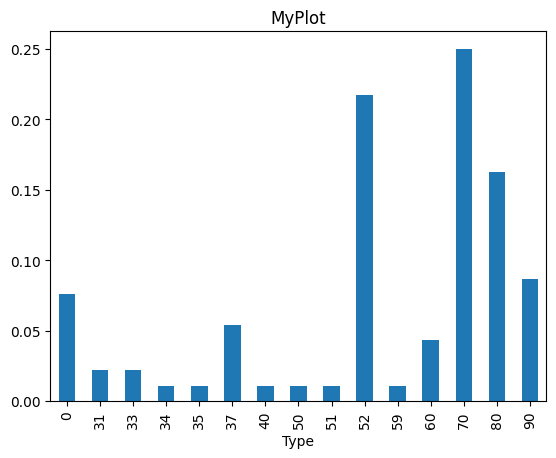

In [46]:
# Plot the proportion 
plot = proportion.sort_index().plot(kind='bar', title='MyPlot')

In [47]:
# Find the different fix types provided
fix_type = geo_raw_ship_data['FixType'].unique()
print(fix_type)

[ 1  0 15  6  3]


0 = Default
1 = GPS
3 = GPS + GLONASS
6 = INS
15 = internal GNSS


-International Maritime Organization (IMO) SHIP IDENTIFICATION NUMBER 
Αποτελεί μοναδικό κωδικό που ανατίθεται σε κάθε πλοίο. Αυτός ο αριθμός χρησιμοποιείται για την ταυτοποίηση και το παρακολούθηση των πλοίων σε διεθνές επίπεδο.


Είτε πρόκειται για ένα μεγάλο φορτηγό πλοίο, ένα πλοίο επιβατών, ένα δεξαμενόπλοιο, 
είτε για ένα μικρότερο σκάφος, η ύπαρξη ενός μοναδικού αναγνωριστικού αριθμού συμβάλλει 
στην παρακολούθηση και διαχείριση των θαλάσσιων δραστηριοτήτων.

In [48]:
# variables for ships with or without IMO number 

# Get Ships with IMO number
Ships_with_IMO_number = geo_raw_ship_data[raw_ship_data["ImoNumber"] != 0]
Total_number_Ships_with_IMO = (geo_raw_ship_data["ImoNumber"] != 0).sum()

# Get Ships without IMO number
Ships_with_no_IMO_number = geo_raw_ship_data[geo_raw_ship_data["ImoNumber"] == 0]
Total_number_Ships_with_no_IMO = (geo_raw_ship_data["ImoNumber"] == 0).sum()

In [49]:
# Get percentage of ships without IMO number
Percentage_of_no_IMO_Ships = (
    Total_number_Ships_with_no_IMO 
    /geo_raw_ship_data["ImoNumber"].count()) * 100
round(Percentage_of_no_IMO_Ships)

24

24% το ποσοστό των πλοίων που δεν διαθέτουν ΙMO number

Κατασκευή ενός γραφήματος διασποράς που θα περιέχει ως dataframe μονο τα πλοία εκείνα που δεν έχουν αριθμό IMO με σκοπό την οπτικοποίηση τους σε χάρτη, βάσει του γεωγραφικού μήκους και πλάτους.
Scatter Plots on Mapbox in Python

In [50]:
# Dataframe of ships with no Imo number, latitude & longitude
Lat_Long_IMO = geo_raw_ship_data[['ImoNumber','latitude','longitude','Destination']]
Lat_Long_of_no_IMO_Ships = Lat_Long_IMO[Lat_Long_IMO["ImoNumber"] == 0].copy().reset_index()
Lat_Long_of_no_IMO_Ships

,index,ImoNumber,latitude,longitude,Destination
0,5,0,31.830750,34.641645,ASHDOD
1,9,0,34.665327,33.041782,LIMASSOL MARINA
2,10,0,34.665240,33.041335,LIMASSOL CYPRUS
3,20,0,31.831317,34.639927,NaN
4,21,0,34.645100,33.014250,LIMASSOL
...,...,...,...,...,...
231,991,0,34.646253,33.021863,LIMASSOL
232,993,0,34.453983,33.299383,-
233,994,0,31.831207,34.640012,NaN
234,996,0,34.670837,33.077082,HAIFA ISRAEL


In [52]:
# Testing for Null values
Null_entries = Lat_Long_of_no_IMO_Ships.isnull().any(axis=1)
null_rows = Lat_Long_of_no_IMO_Ships[Null_entries]
null_rows

,index,ImoNumber,latitude,longitude,Destination
3,20,0,31.831317,34.639927,NaN
6,32,0,31.831242,34.639950,NaN
11,68,0,34.664468,33.029690,NaN
12,77,0,31.642125,34.531130,NaN
15,93,0,31.831232,34.639995,NaN
22,150,0,31.831103,34.640052,NaN
27,186,0,34.664468,33.029693,NaN
30,210,0,31.831085,34.640077,NaN
35,247,0,34.664477,33.029693,NaN
38,269,0,31.831223,34.639997,NaN


In [90]:
import geopandas as gpd
import plotly.express as px
fig = px.scatter_geo(Lat_Long_of_no_IMO_Ships,
lat = 'latitude',
lon = 'longitude',
)
fig.show()

Συμπερασματικά, απο το dataframe των πλοίων χωρίς IMO αριθμό παρατηρείται πως τα περισσότερα δεν βρίσκονται σε πλέυση το δεδομένο διάστημα συλλογής των data

In [54]:
# Find the ship with the most data
geo_raw_ship_data['ShipName'].value_counts()

ShipName
DEBBIE            27
SYMPHONY          18
IRIS              17
ASHDOD PORT       17
EDT LEON          17
                  ..
ELAD               1
VTS KERYNEIA       1
ADA 74             1
AKRITAS            1
SUSAN BORCHARD     1
Name: count, Length: 91, dtype: int64

In [56]:
# Return a dataframe with only the data we need in order to plot trajectories
ship_data = geo_raw_ship_data[['time_utc','ShipName','MMSI','geometry']]
ship_data.head()

,time_utc,ShipName,MMSI,geometry
0,2023-12-09 08:05:51,SEMINOLE,247274900,POINT (33.05835 34.66968)
1,2023-12-09 08:05:54,EDT ZENON,212541000,POINT (33.00969 34.64540)
2,2023-12-09 08:05:57,KOSOVAK,271047045,POINT (29.00512 35.82620)
3,2023-12-09 08:06:05,EDT LEON,209343000,POINT (33.00900 34.64513)
4,2023-12-09 08:06:08,NAVAL AUXILIARY A135,233303000,POINT (33.01678 34.65245)


In [60]:
# Get vessel "Debbie" wich has the most records
ship_name_value="DEBBIE"
results = ship_data[ship_data["ShipName"] == ship_name_value]
print(results.head())

                time_utc ShipName       MMSI                   geometry
35   2023-12-09 08:09:28   DEBBIE  667001448  POINT (34.64196 31.82850)
45   2023-12-09 08:10:41   DEBBIE  667001448  POINT (34.64197 31.82847)
69   2023-12-09 08:12:56   DEBBIE  667001448  POINT (34.64197 31.82847)
127  2023-12-09 08:18:30   DEBBIE  667001448  POINT (34.64190 31.82863)
163  2023-12-09 08:22:48   DEBBIE  667001448  POINT (34.64196 31.82861)


In [61]:
traj_collection = mpd.TrajectoryCollection(results, 'MMSI', t='time_utc', min_length=100)

/home/entech/.local/lib/python3.10/site-packages/movingpandas/trajectory_generalizer.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_t = temp_df.head(1)["t"][0]


<Axes: >

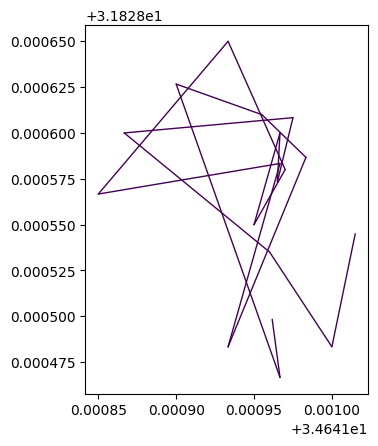

In [63]:
traj_collection = mpd.MinTimeDeltaGeneralizer(traj_collection).generalize(tolerance=timedelta(minutes=1))
traj_collection.plot(column='MMSI', linewidth=1, capstyle='round')


In [65]:
my_traj = traj_collection.trajectories[0]
my_traj.df.head()
my_traj.hvplot(title=f'Trajectory {my_traj.id}', frame_width=700, frame_height=500, line_width=5.0, cmap='Dark2') 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (triangle_angle)